In [80]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
DATA_PATH = "../../FPGA/TVP5147M1_decoder_interface/simulation/modelsim/data/"

The requirements for verilog module with the video

1. independent of exact formmat
2. must 


In [3]:

video_file = "video.mp4"

In [4]:
TOTAL_LINES = 525
TOTAL_ACTIVE_LINES = 480
TOTAL_PIXELS = 858
TOTAL_ACTIVE_PIXELS = 720
TOTAL_BLANKING_PIXELS = TOTAL_PIXELS - TOTAL_ACTIVE_PIXELS

preamble = [0xFF, 0x00, 0x00]
# https://pub.smpte.org/pub/st293/st0293-2003_stable2010.pdf, table 3
SAV_active = 0b10000000
EAV_active = 0b10011101
SAV_VBI = 0b10101011
EAV_VBI = 0b10110110

EAV_START = 2 * TOTAL_ACTIVE_PIXELS
SAV_START =  2 * TOTAL_PIXELS - 4

DEFAULT_Y = 16
DEFAULT_C = 128
# what is going on during vertical blanking?
# todo do for one frame

In [6]:
# todo clamp values between 1 and 254
cap = cv2.VideoCapture(video_file)
global_frame = np.zeros((TOTAL_ACTIVE_LINES, TOTAL_ACTIVE_PIXELS, 3), np.uint8)

counter = 0
all_frames = []
while (1):
    ret, frame = cap.read()

    if cv2.waitKey(1) & 0xFF == ord('q') or ret == False:
        cap.release()
        cv2.destroyAllWindows()
        break

    frame = cv2.resize(frame, (720, 480), cv2.INTER_AREA)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)
    frame = np.clip(frame, 1, 254)

    lines = np.zeros((TOTAL_LINES, 2 * TOTAL_PIXELS)).astype(np.uint8)
    # YCrCb 4:2:2
    Y = frame[:, :, 0]
    Cr = frame[:, ::2, 1]
    Cb = frame[:, ::2, 2]

    lines[:, 0::2] = DEFAULT_C
    lines[:, 1::2] = DEFAULT_Y
    
    lines[:, EAV_START: EAV_START + 3] = preamble
    lines[:, SAV_START: SAV_START + 3] = preamble

    lines[:TOTAL_ACTIVE_LINES, EAV_START + 3] = EAV_active
    lines[:TOTAL_ACTIVE_LINES, SAV_START + 3] = SAV_active


    lines[TOTAL_ACTIVE_LINES:, EAV_START + 3] = EAV_VBI
    lines[TOTAL_ACTIVE_LINES:, SAV_START + 3] = SAV_VBI

    lines[:TOTAL_ACTIVE_LINES, 0:2 * TOTAL_ACTIVE_PIXELS:4] = Cr
    lines[:TOTAL_ACTIVE_LINES, 1:2 * TOTAL_ACTIVE_PIXELS:2] = Y
    lines[:TOTAL_ACTIVE_LINES, 2:2 * TOTAL_ACTIVE_PIXELS:4] = Cb


    

    x_roll = 4
    lines = np.roll(lines, x_roll)
    lines[0][x_roll-1] = SAV_active
    lines[-1][EAV_START + 4 + x_roll - 1] = EAV_active
    lines = np.roll(lines, TOTAL_LINES - TOTAL_ACTIVE_LINES, 0)
    # lines[TOTAL_LINES - TOTAL_ACTIVE_LINES - 1][2*TOTAL_ACTIVE_PIXELS + 4 - 1] = SAV_active
    lines[0][x_roll-1] = SAV_VBI
    lines[-1][EAV_START + 4 + x_roll - 1] = EAV_VBI



    # Cr = lines[:, 0::4]
    # Y  = lines[:, 1::2]
    # Cb = lines[:, 2::4]
    # 
    # Cr = np.repeat(Cr, 2, axis=1)
    # Cb = np.repeat(Cb, 2, axis=1)
    # new_frame = np.zeros((TOTAL_LINES, TOTAL_PIXELS, 3)).astype(np.uint8)
    # new_frame[:,:,0] = Y
    # new_frame[:,:,1] = Cr
    # new_frame[:,:,2] = Cb
    # cv2.imshow('frame', cv2.cvtColor(new_frame, cv2.COLOR_YCrCb2BGR))

    cv2.imshow('frame', lines)
    # if cv2.waitKey(0) & 0xFF == ord('q'):
    #     cv2.destroyAllWindows()
    #     break
    lines = lines.flatten()
    all_frames.append(lines)


    counter += 1

In [311]:
FRAME_CNT = 60
all_frames = np.array(all_frames[:FRAME_CNT]).flatten()

In [11]:
len(all_frames) / 1000 ** 2

196.3962

In [7]:
len(all_frames)

218

In [9]:
with open(f"video_f{len(all_frames)}.bin", "wb") as fd:
    fd.write(np.array(all_frames).flatten())

In [223]:
# with open("video.bin", "rb") as fd:
#     all_frames_read =  fd.read()
with open(f"video_f{FRAME_CNT}.bin", "rb") as fd:
    all_frames_read =  fd.read()

In [224]:
all_frames_read = np.array([*all_frames_read])

In [225]:
del all_frames_read
del all_frames

In [198]:
all_frames_read.shape

(54054000,)

In [199]:
all_frames =  np.reshape(all_frames_read, (-1, TOTAL_LINES * 2 * TOTAL_PIXELS)).astype(np.uint8)


In [270]:
try:
    for frame in all_frames:
        frame = np.reshape(frame, (TOTAL_LINES, 2 * TOTAL_PIXELS))
        frame = np.roll(frame, -4)
        frame = np.roll(frame, -(TOTAL_LINES - TOTAL_ACTIVE_LINES), 0)
        frame = frame[:TOTAL_ACTIVE_LINES, :2 * TOTAL_ACTIVE_PIXELS]
        Cr = frame[:TOTAL_ACTIVE_LINES, 0:2 * TOTAL_ACTIVE_PIXELS:4]
        Y  = frame[:TOTAL_ACTIVE_LINES, 1:2 * TOTAL_ACTIVE_PIXELS:2]
        Cb = frame[:TOTAL_ACTIVE_LINES, 2:2 * TOTAL_ACTIVE_PIXELS:4]

        Cr = np.repeat(Cr, 2, axis=1)
        Cb = np.repeat(Cb, 2, axis=1)
        
        new_frame = np.zeros((TOTAL_ACTIVE_LINES, TOTAL_ACTIVE_PIXELS, 3)).astype(np.uint8)
        new_frame[:,:,0] = Y
        new_frame[:,:,1] = Cr
        new_frame[:,:,2] = Cb
        
        frame = cv2.cvtColor(new_frame, cv2.COLOR_YCrCb2BGR)

        # frame = frame[:100, :100]
        # frame = cv2.resize(frame, (480, 480))
        cv2.imshow('frame', frame)
        if cv2.waitKey(33) & 0xFF == ord('q'):
            # cap.release()
            cv2.destroyAllWindows()
            break
finally:
    cv2.destroyAllWindows()
    


ValueError: cannot reshape array of size 1 into shape (525,1716)

In [10]:
def bt656_to_bgr(frame, roll_x = True, roll_y = True):
    frame = np.array(frame)
    if (roll_x):
        frame = np.roll(frame, -4)
    if (roll_y):
        frame = np.roll(frame, -(TOTAL_LINES - TOTAL_ACTIVE_LINES), 0)

    frame = frame[:TOTAL_ACTIVE_LINES, :2 * TOTAL_ACTIVE_PIXELS]
    Cr = frame[:TOTAL_ACTIVE_LINES, 0:2 * TOTAL_ACTIVE_PIXELS:4]
    Y  = frame[:TOTAL_ACTIVE_LINES, 1:2 * TOTAL_ACTIVE_PIXELS:2]
    Cb = frame[:TOTAL_ACTIVE_LINES, 2:2 * TOTAL_ACTIVE_PIXELS:4]
    
    Cr = np.repeat(Cr, 2, axis=1)
    Cb = np.repeat(Cb, 2, axis=1)
    new_frame = np.zeros((TOTAL_ACTIVE_LINES, TOTAL_ACTIVE_PIXELS, 3)).astype(np.uint8)
    new_frame[:,:,0] = Y
    new_frame[:,:,1] = Cr
    new_frame[:,:,2] = Cb
    
    frame = cv2.cvtColor(new_frame, cv2.COLOR_YCrCb2BGR)
    return frame

In [55]:

def decode_and_display_video(video_file_name, decode_bt656 = True, slow_down_coeff = 1, max_frames = None, return_all_frames=False, save_video = False):
    with open(video_file_name, "rb") as fd:
        all_frames_read =  fd.read()
    all_frames_read = np.array([*all_frames_read])
    i_prev1 = 0
    el_prev3 = None
    el_prev2 = None
    el_prev1 = None
    first_sav = None
    last_eav = None
    sav_cnt = 0
    for i, el in enumerate(all_frames_read):
        # print(el_prev3, el_prev2, el_prev1, el)
        if (el_prev3 == preamble[0] 
                and el_prev2 == preamble[1] 
                and el_prev1 == preamble[2] 
                and (el == SAV_active or el == SAV_VBI)):
            first_sav = i
            sav_cnt += 1
            if sav_cnt == 1:
                break
        if (el_prev3 == preamble[0]
                and el_prev2 == preamble[1]
                and el_prev1 == preamble[2]
                and (el == EAV_active)):
            last_eav = i
        el_prev3 = el_prev2
        el_prev2 = el_prev1
        el_prev1 = el
    # print(first_sav,last_eav)
    points_per_frame = TOTAL_LINES * 2 * TOTAL_PIXELS
    all_frames_read = all_frames_read[first_sav - 3:]
    all_frames_read = all_frames_read[:((len(all_frames_read))//points_per_frame)*points_per_frame]
    all_frames_read =  np.reshape(all_frames_read, (-1, points_per_frame)).astype(np.uint8)
    # if return_all_frames:
    frames = []
    if save_video:
        save_path = os.path.splitext(os.path.basename(video_file_name))[0] + ".mp4"
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        video = cv2.VideoWriter(save_path, fourcc, int(np.ceil(30*slow_down_coeff)), (TOTAL_ACTIVE_PIXELS, TOTAL_ACTIVE_LINES))
    try:
        if max_frames is None:
            max_frames = len(all_frames_read)
        
        max_frames = min(max_frames, len(all_frames_read)) 
        for frame in all_frames_read[:max_frames]:
            
            frame = np.reshape(frame, (TOTAL_LINES, 2 * TOTAL_PIXELS))

            if decode_bt656:
                frame = bt656_to_bgr(frame)
            if return_all_frames:
                frames.append(frame)
            if save_video:
                video.write(frame)
            # frame = frame[:100, :100]
            # frame = cv2.resize(frame, (480, 480))
            cv2.imshow('frame', frame)
            if cv2.waitKey(int(33/slow_down_coeff)) & 0xFF == ord('q'):
                # cap.release()
                cv2.destroyAllWindows()
                if return_all_frames:
                    return frames
                return frame
    except Exception as e:
        print(e)
    finally:
        cv2.destroyAllWindows()
        if return_all_frames:
            return frames
        return frame
        

('video_f60_scrambled_scrambler', '.bin')

In [ ]:
%%sql


In [28]:
with open(os.path.join(DATA_PATH,"video_f60_scrambled_scrambler.bin"), "rb") as f:
    data = f.read()

data2 = data[len(data)//2:]
with open(os.path.join(DATA_PATH,"video_f60_scrambled_scrambler2.bin"), "wb") as f:
    f.write(data2)


In [366]:
# filename = "video_f60_descrambled_drbg.bin"
filename = "church_f10_scrambled_seed0.bin"
frame = decode_and_display_video(os.path.join(DATA_PATH,filename), decode_bt656=True, slow_down_coeff=0.1, save_video=True)

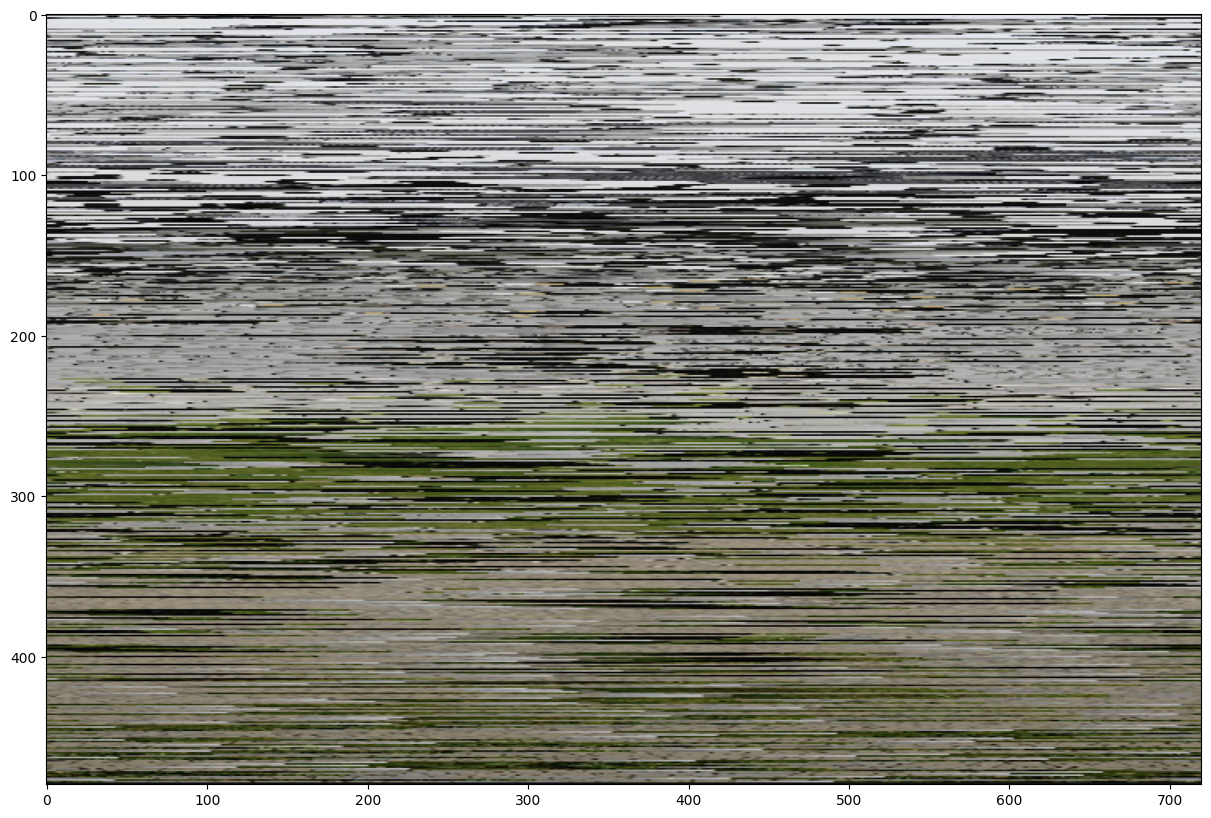

In [233]:
plt.figure(figsize=(20, 10))
plt.imshow(frame if len(frame.shape) == 2 else cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), cmap= "gray" if len(frame.shape) == 2 else None)

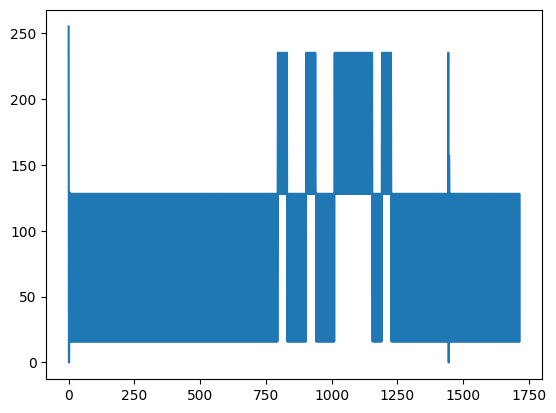

In [18]:
plt.plot(frame[44])

In [ ]:
frame_normal = decode_and_display_video(os.path.join(DATA_PATH, "video_f60.bin"), decode_bt656=False, slow_down_coeff=0.1, max_frames = 10)

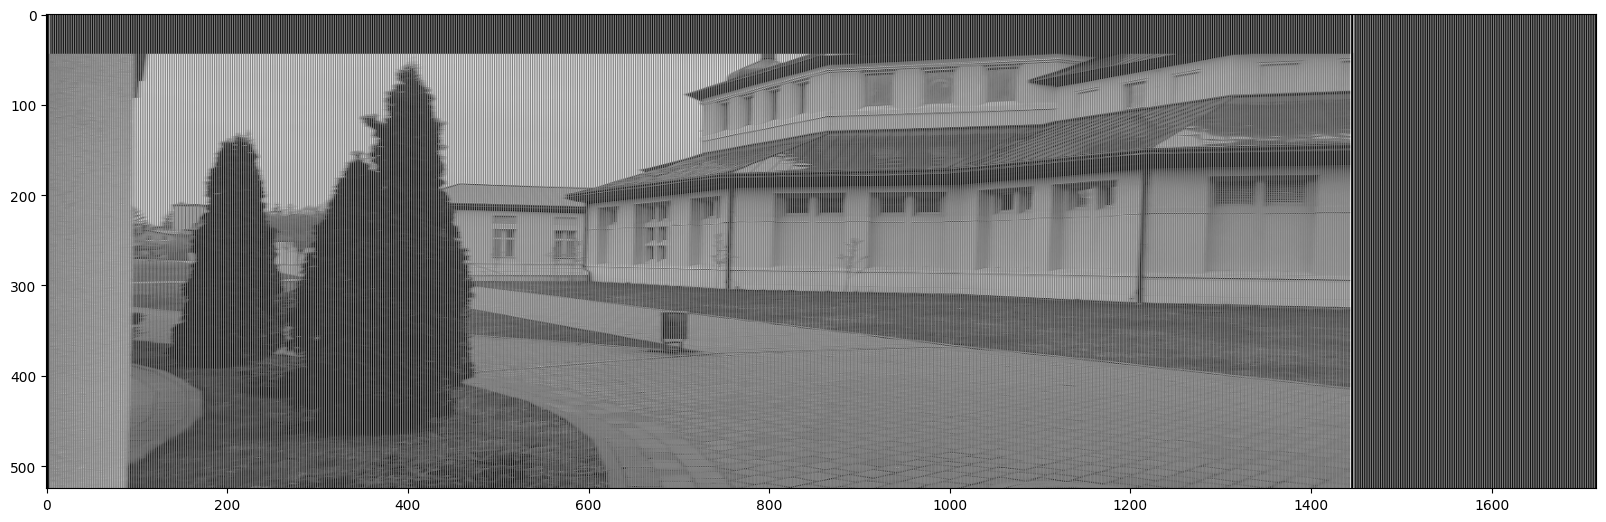

In [389]:
plt.figure(figsize=(20, 10))
plt.imshow(frame_normal if len(frame_normal.shape) == 2 else cv2.cvtColor(frame_normal, cv2.COLOR_BGR2RGB), cmap= "gray" if len(frame_normal.shape) == 2 else None)

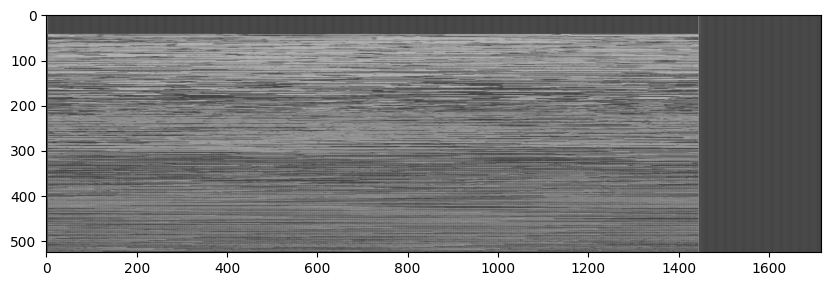

In [365]:
# filename = "video_f60_descrambled_scrambler2.bin"
# filename = "video_f60_descrambled_drbg.bin"
# filename = "church_f218_descrambled_seed0.bin"
filename = "church_f10_descrambled_seed0.bin"
frame_decrypted = decode_and_display_video(os.path.join(DATA_PATH, filename), decode_bt656=True, slow_down_coeff=0.1, save_video=True)

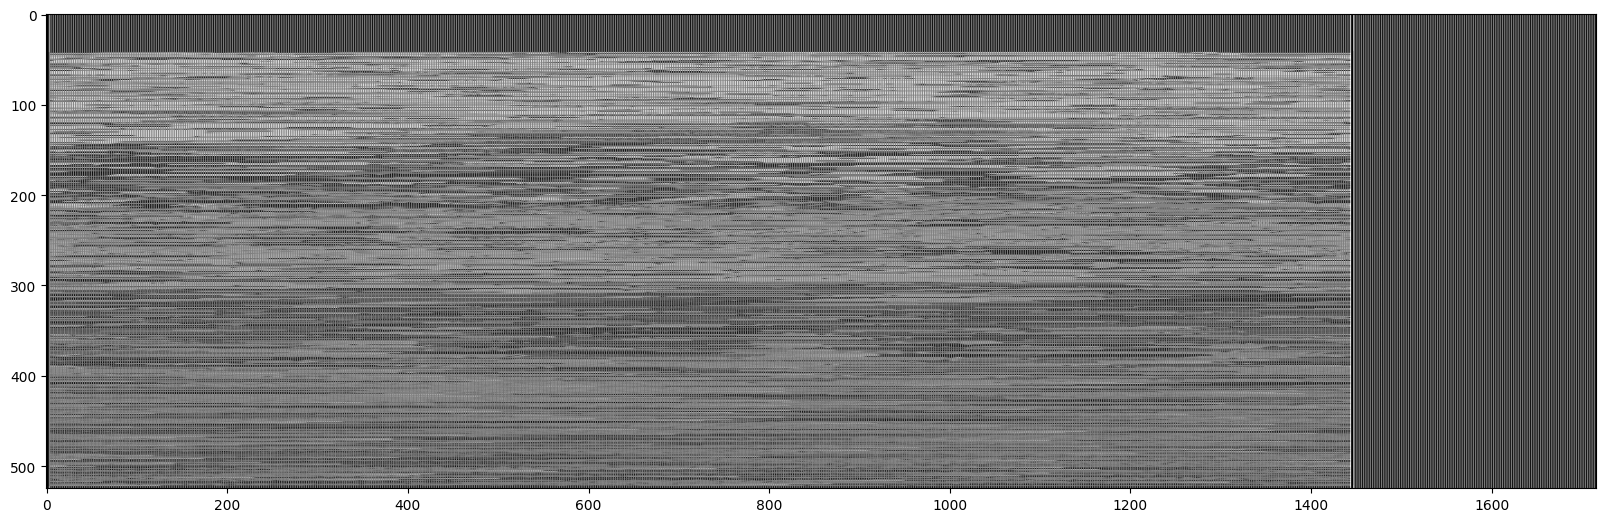

In [359]:
plt.figure(figsize=(20, 20))
plt.imshow(frame_decrypted if len(frame_decrypted.shape) == 2 else cv2.cvtColor(frame_decrypted, cv2.COLOR_BGR2RGB), cmap= "gray" if len(frame.shape) == 2 else None)

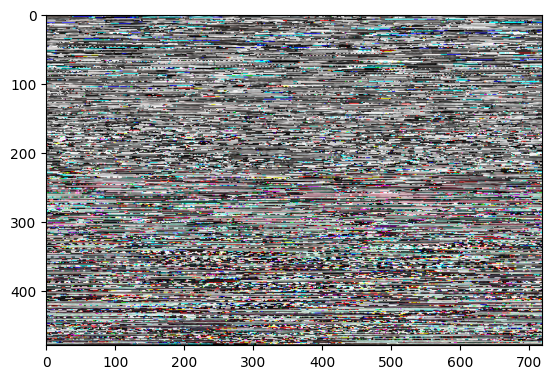

In [339]:
plt.imshow(frame_decrypted - frame)

5.477225575051661

## Attempt at breaking the scrambler

In [354]:
# O(m * n ^ 2) or 360 times slower frame processing
reference_line = frame[TOTAL_LINES - TOTAL_ACTIVE_LINES][4:2*TOTAL_ACTIVE_PIXELS + 4]
unrolled_frame = [reference_line] 
for i in range(TOTAL_LINES - TOTAL_ACTIVE_LINES + 1, len(frame)):
    line = frame[i][4:2*TOTAL_ACTIVE_PIXELS + 4]
    rolled_line = line 
    distances = []
    for j in range(0, len(line), 4):
        # distances.append(np.linalg.norm(reference_line - rolled_line))
        distances.append(np.sum(np.abs(reference_line - rolled_line)))
        rolled_line = np.roll(rolled_line, 4, axis=0)
    optimal_roll = np.argmin(distances)
    reference_line = np.roll(line, optimal_roll * 4, axis=0)
    unrolled_frame.append(reference_line)


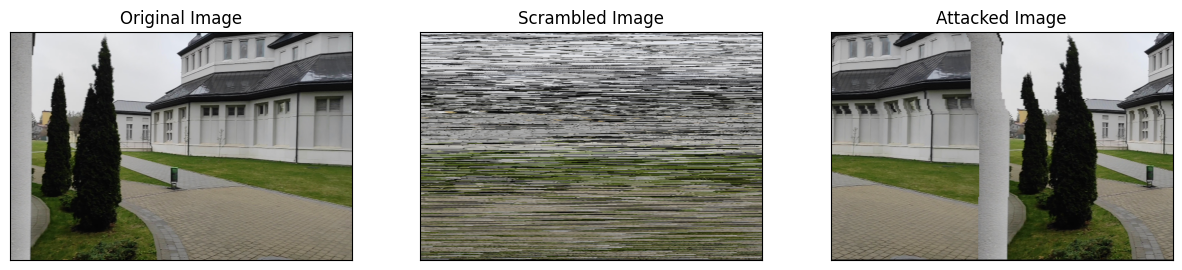

In [355]:

plt.figure(figsize=(15,5))
plt.subplot(131),plt.imshow(cv2.cvtColor(frame_normal, cv2.COLOR_BGR2RGB),cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(cv2.cvtColor(bt656_to_bgr(frame), cv2.COLOR_BGR2RGB),cmap = 'gray')
plt.title('Scrambled Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(cv2.cvtColor(bt656_to_bgr(unrolled_frame, roll_x=False, roll_y=False), cv2.COLOR_BGR2RGB),cmap = 'gray')
plt.title('Attacked Image'), plt.xticks([]), plt.yticks([])
plt.show()

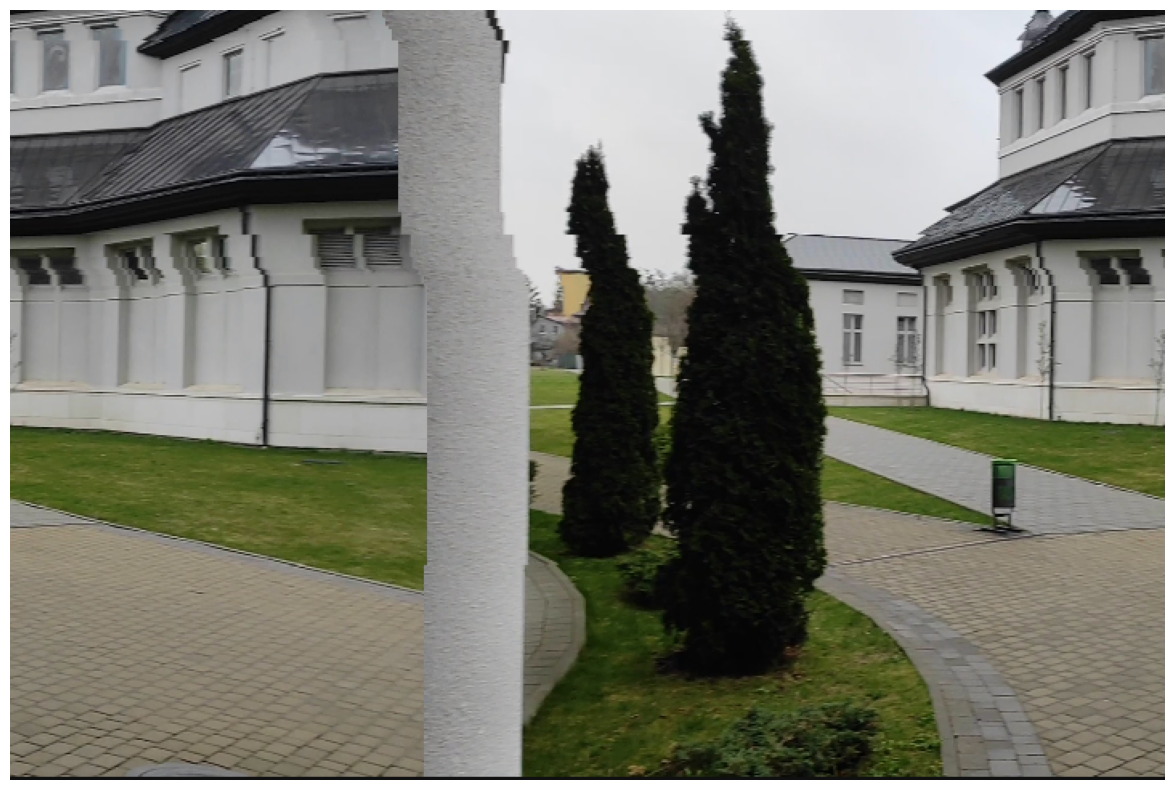

In [165]:
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(cv2.cvtColor(bt656_to_bgr(unrolled_frame, roll_x=False), cv2.COLOR_BGR2RGB), cmap="gray")

In [352]:
from  typing import Literal
def attack_line_rotator_frame(frame, previous_frame_first_reference_line = None, metric: Literal["l1", "entropy"] = "l1"):
    # O(m * n ^ 2) or 360 times slower frame processing
    if (previous_frame_first_reference_line is None):
        reference_line = frame[TOTAL_LINES - TOTAL_ACTIVE_LINES][4:2*TOTAL_ACTIVE_PIXELS + 4]
        unrolled_frame = [reference_line]
        offset = 1
    else:
        reference_line = previous_frame_first_reference_line[4:2*TOTAL_ACTIVE_PIXELS + 4]
        unrolled_frame = []
        offset = 0
    for i in range(TOTAL_LINES - TOTAL_ACTIVE_LINES + offset, len(frame)):
        line = frame[i][4:2*TOTAL_ACTIVE_PIXELS + 4]
        rolled_line = line
        distances = []
        for j in range(0, len(line), 4):
            # distances.append(np.linalg.norm(reference_line - rolled_line))
            match metric:
                case "l1":
                    m = np.sum(np.abs(reference_line.astype(np.int16) - rolled_line))
                case "entropy":
                    diff = np.abs(reference_line.astype(np.int16) - rolled_line)
                    probability = np.array(np.sum(diff == c) for c in range(256))
                    probability = probability[probability > 0]
                    probability = probability / len(diff)
                    m = -np.sum(probability * np.log2(probability))
            distances.append(m)
            rolled_line = np.roll(rolled_line, 4, axis=0)
        optimal_roll = np.argmin(distances)
        reference_line = np.roll(line, optimal_roll * 4, axis=0)
        unrolled_frame.append(reference_line)
    return bt656_to_bgr(unrolled_frame, roll_x=False, roll_y=False)

In [27]:
frames = decode_and_display_video(os.path.join(DATA_PATH,"church_f218_scrambled_seed0.bin"), decode_bt656=False, slow_down_coeff=1, return_all_frames=True)

In [334]:
(np.array(20, dtype=np.uint8) - np.array(30, dtype=np.uint8)).astype(np.int16)

246

In [353]:
import tqdm
attacked_frames = []
i_prev = None
for i in tqdm.tqdm(frames, position=0, leave=True):
    attacked_frame = attack_line_rotator_frame(i, None if i_prev is None else i_prev[0])
    i_prev = i
    attacked_frames.append(attacked_frame)

100%|██████████| 217/217 [09:17<00:00,  2.57s/it]


In [357]:
slow_down_coeff = 1

# choose codec according to format needed
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter('church_f218_attacked_seed0.mp4', fourcc, 30, (TOTAL_ACTIVE_PIXELS, TOTAL_ACTIVE_LINES))

    

for frame in attacked_frames:
    cv2.imshow('frame', frame)
    video.write(frame)
    if cv2.waitKey(int(33/slow_down_coeff)) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break
cv2.destroyAllWindows()
video.release()


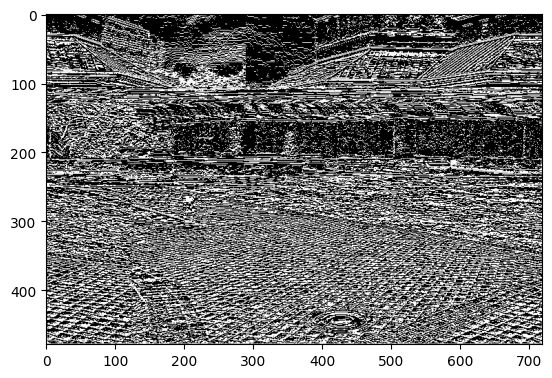

In [274]:
attacked_diff = cv2.cvtColor(attacked_frames[40], cv2.COLOR_BGR2GRAY)

attacked_diff = np.diff(attacked_diff, axis=0)
attacked_diff[attacked_diff < 150] = 0
plt.imshow(attacked_diff, cmap="gray")

(array([186636.,  10567.,   4361.,   2400.,   1311.,   1392.,   2724.,
          4368.,   9942., 121179.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

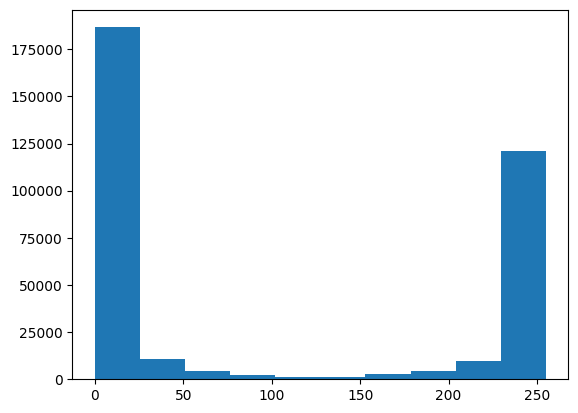

In [265]:
plt.hist(attacked_diff.flatten())

In [339]:
def calculate_DY_entropy(image, do_DY = True):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) != 2 else image
    if do_DY:
        DY = np.diff(image, axis=0)
    else: DY = image
    hist = cv2.calcHist([DY], [0], None, [256], [0, 256]) 
    hist = hist[hist > 0]
    hist /= image.size
    return -np.sum(hist * np.log2(hist)) 

In [319]:
descrambled_frames = decode_and_display_video(os.path.join(DATA_PATH,"church_f218_descrambled_seed0.bin"), decode_bt656=True, slow_down_coeff=1, return_all_frames=True)

In [322]:
len(attacked_entropy)

217

In [340]:
raw_decrypted_entropy, decrypted_entropy, attacked_entropy, encrypted_entropy = zip(*[(
                                             calculate_DY_entropy(descrambled_frames[i], False),
                                             calculate_DY_entropy(descrambled_frames[i]), 
                                             calculate_DY_entropy(attacked_frames[i]),
                                             calculate_DY_entropy(bt656_to_bgr(frames[i]))) 
                                        for i in range(len(frames))])

Text(0, 0.5, 'Entropy')

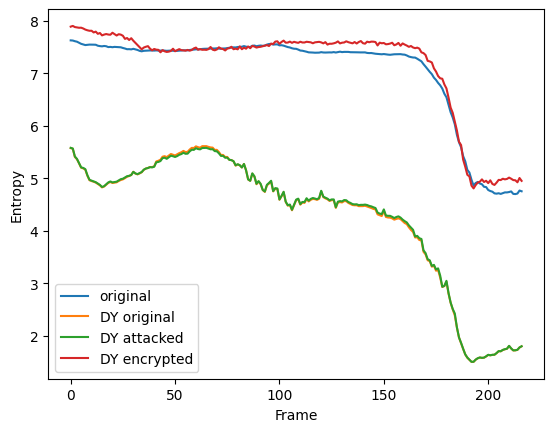

In [341]:
plt.plot(raw_decrypted_entropy)
plt.plot(decrypted_entropy)
plt.plot(attacked_entropy)
plt.plot(encrypted_entropy)
plt.legend(["original", "DY original", "DY attacked", "DY encrypted"])
plt.xlabel("Frame")
plt.ylabel("Entropy")

Text(0, 0.5, 'Entropy')

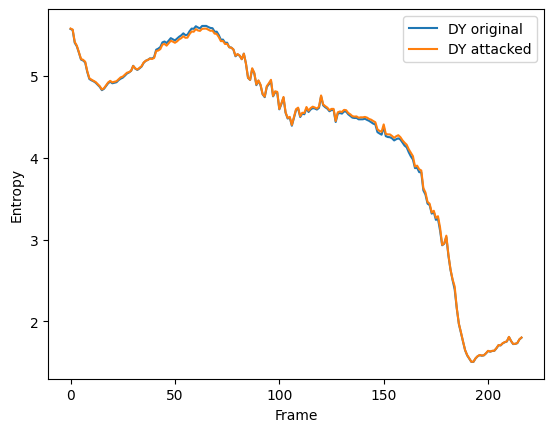

In [358]:
plt.plot(decrypted_entropy)
plt.plot(attacked_entropy)
plt.legend(["DY original", "DY attacked"])
plt.xlabel("Frame")
plt.ylabel("Entropy")

Text(0, 0.5, 'Entropy')

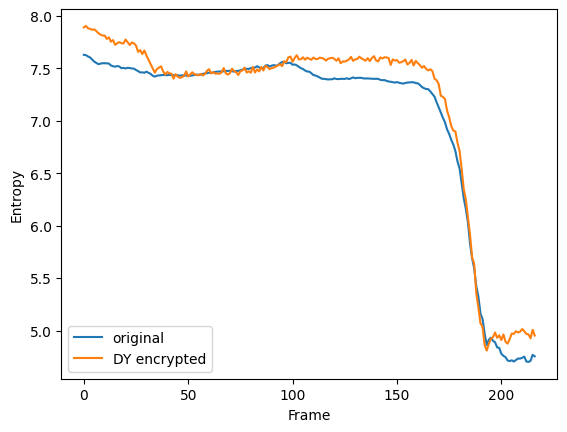

In [359]:
plt.plot(raw_decrypted_entropy)
plt.plot(encrypted_entropy)
plt.legend(["original", "DY encrypted"])
plt.xlabel("Frame")
plt.ylabel("Entropy")

In [346]:
np.sum((np.array(attacked_entropy) - np.array(decrypted_entropy)) ** 2) / len(decrypted_entropy)

0.00036707530785266157

In [347]:
np.sum((np.array(raw_decrypted_entropy) - np.array(encrypted_entropy)) ** 2) / len(decrypted_entropy)

0.025999390035181

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(frame, cmap="gray")

In [35]:
new_frame.shape

(480, 720, 3)

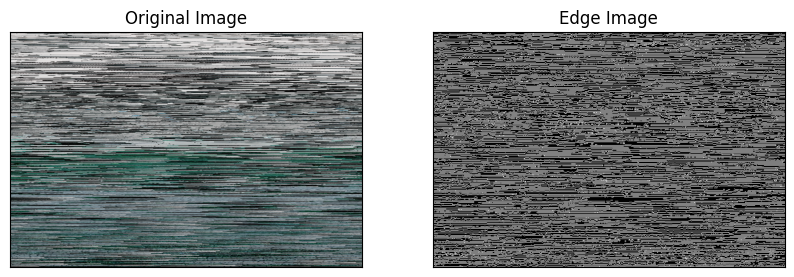

In [25]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = frame
assert img is not None, "file could not be read, check with os.path.exists()"
edges = cv.Canny(img,100,200)
plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

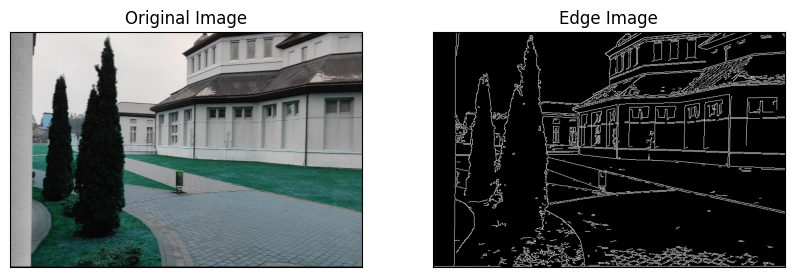

In [39]:
img = frame_normal
assert img is not None, "file could not be read, check with os.path.exists()"
edges = cv.Canny(img,100,200)
plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [53]:
cv2.getGaussianKernel(5, 1).T[0]

array([0.05448868, 0.24420134, 0.40261995, 0.24420134, 0.05448868])

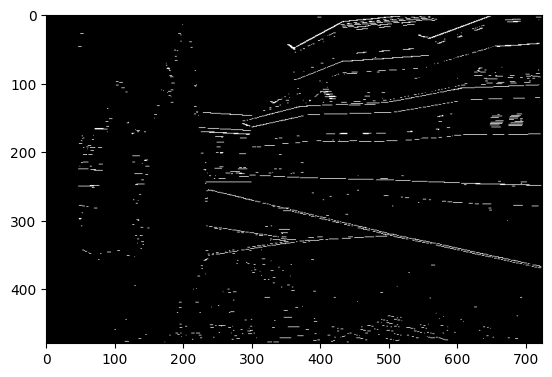

In [74]:
kernel = cv2.getGaussianKernel(5, 5).T[0]
img = np.diff([np.convolve(i, kernel) for i in cv2.cvtColor(frame_normal, cv2.COLOR_BGR2GRAY)], axis=0)
img[img < 30] = 0
img[img >= 30] = 255
plt.imshow(img, cmap="gray")

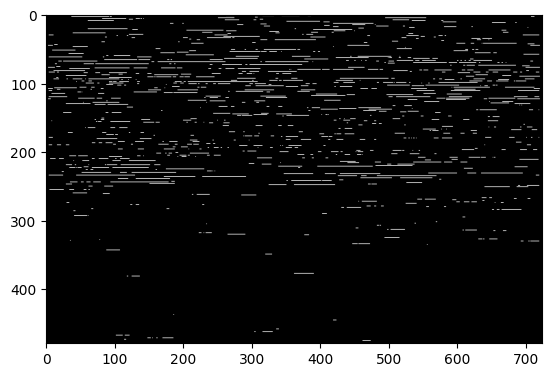

In [83]:
kernel = cv2.getGaussianKernel(5, 5).T[0]
img = np.diff([np.convolve(i, kernel) for i in cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)], axis=0)
thresh = 150
img[img < thresh] = 0
img[img >= thresh] = 255
plt.imshow(img, cmap="gray")

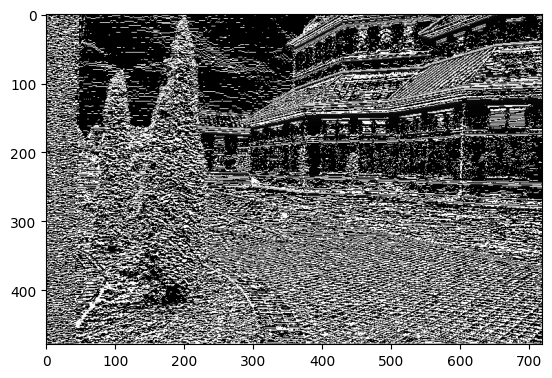

In [41]:
plt.imshow(np.diff(cv2.cvtColor(frame_normal, cv2.COLOR_BGR2GRAY), axis=0), cmap="gray")

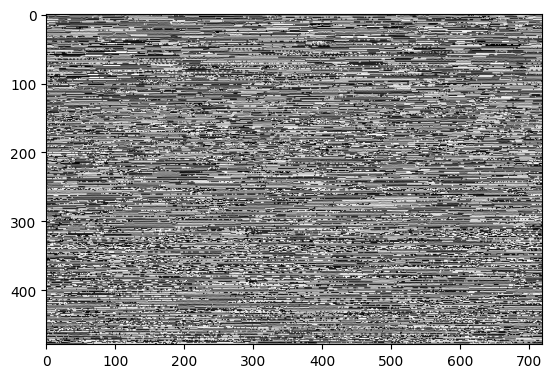

In [40]:
plt.imshow(np.diff(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), axis=0), cmap="gray")

In [224]:
all_video = []
with open("yuv422p.yuv", "rb") as f:
    all_video = f.read(720 * 2 * 480 * 4)

In [225]:
all_video = np.array([int(i) for i in all_video], dtype=np.uint8)

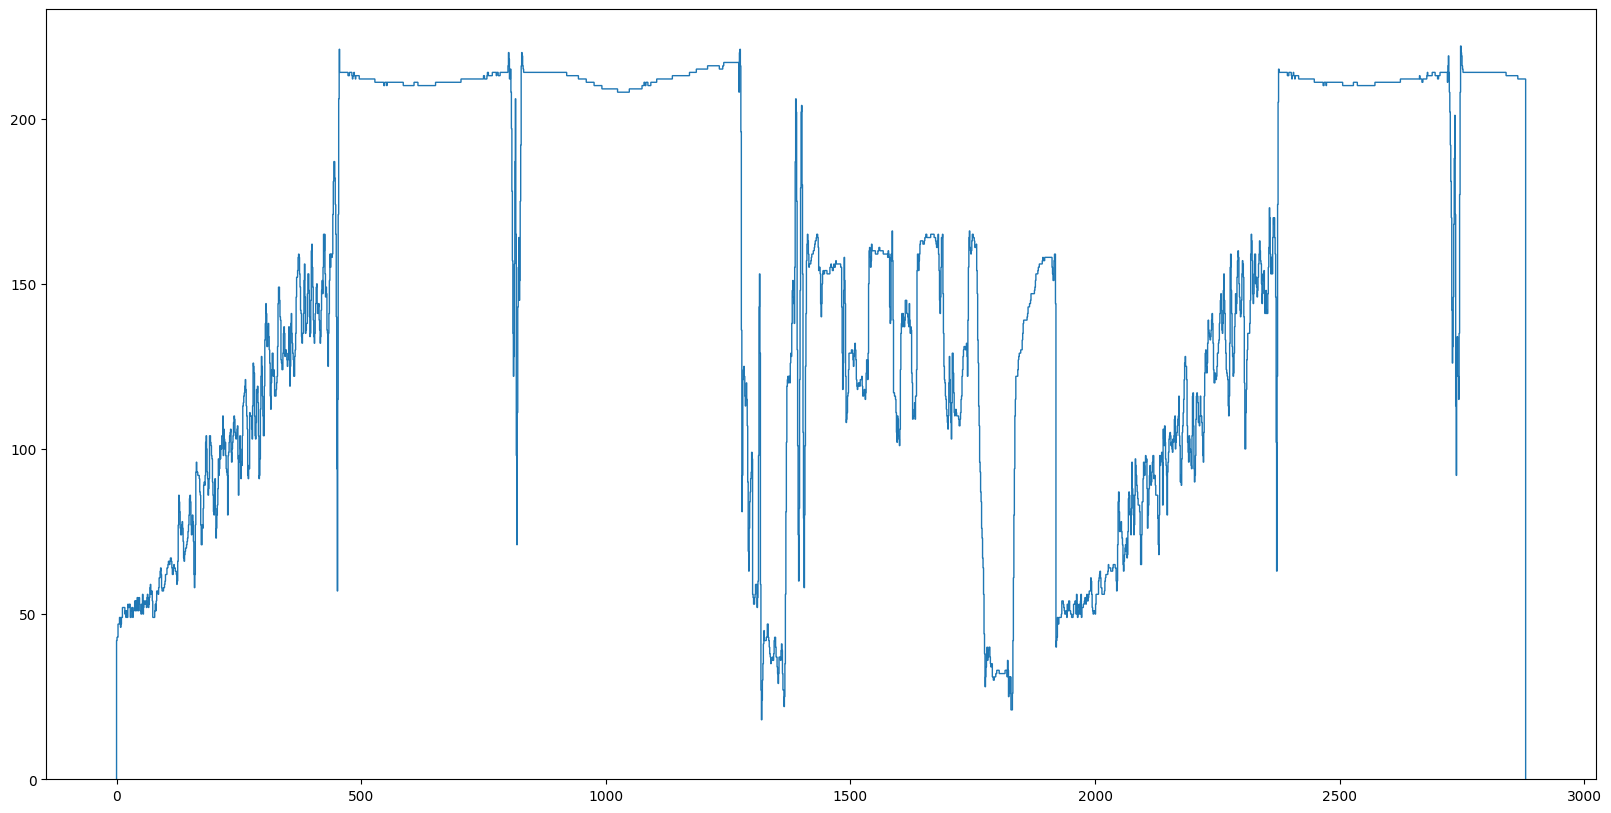

In [226]:
plt.figure(figsize=(20,10))
plt.stairs(all_video[1:720 * 8:2])

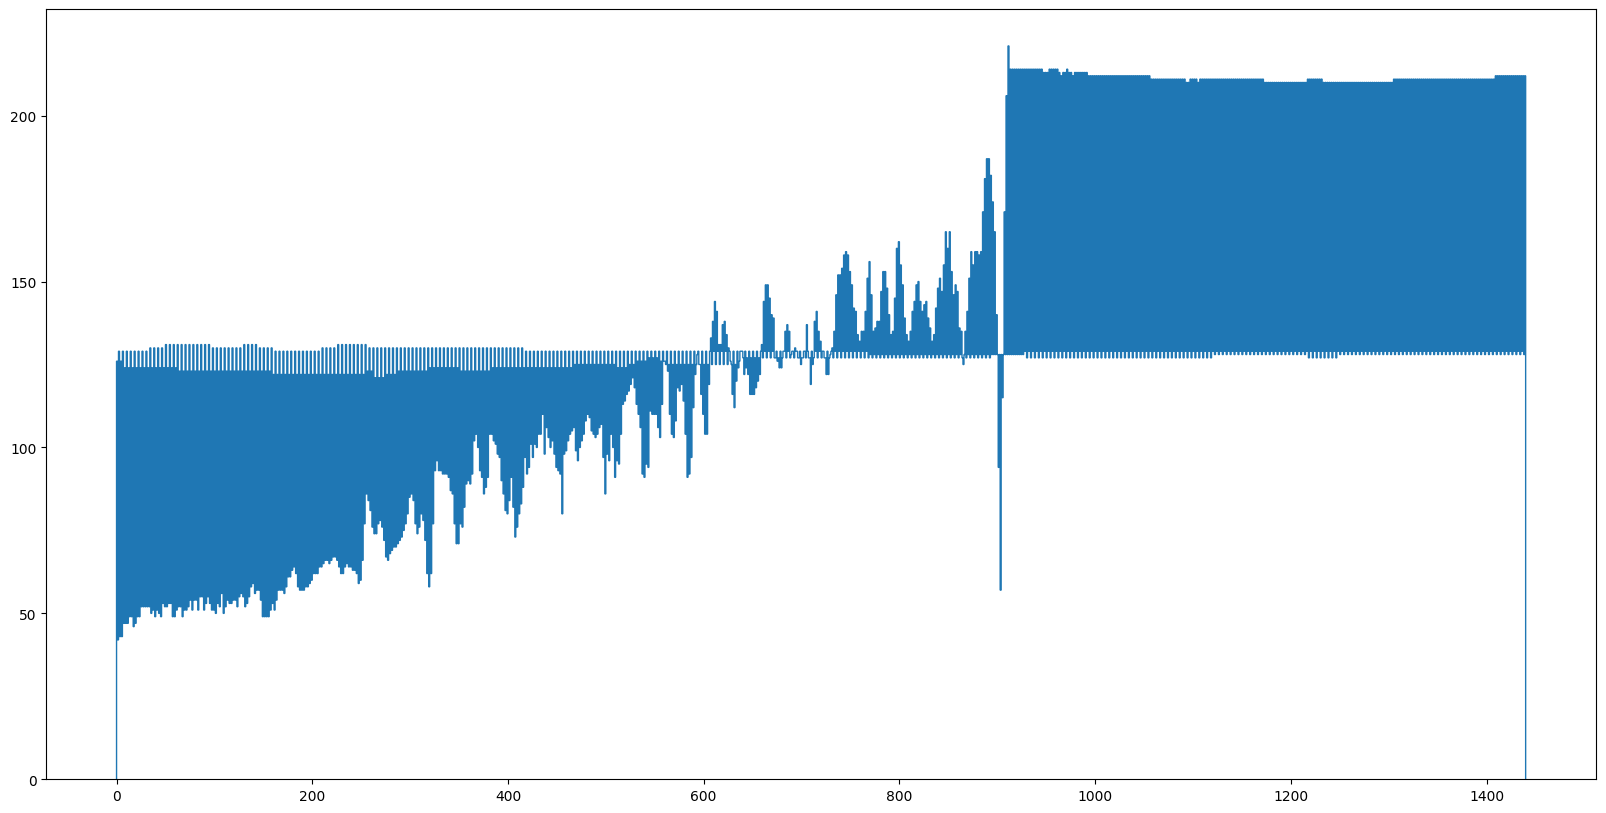

In [227]:
plt.figure(figsize=(20,10))
plt.stairs(all_video[:720*2])

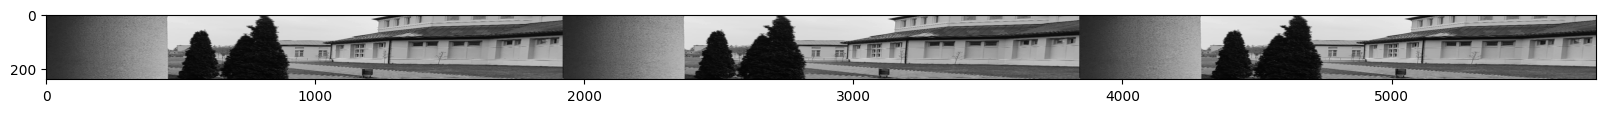

In [230]:
all_video_reshaped = all_video[1::2].reshape((-1, 720 * 8 ))
plt.figure(figsize=(20,10))

plt.imshow(all_video_reshaped, cmap="gray")

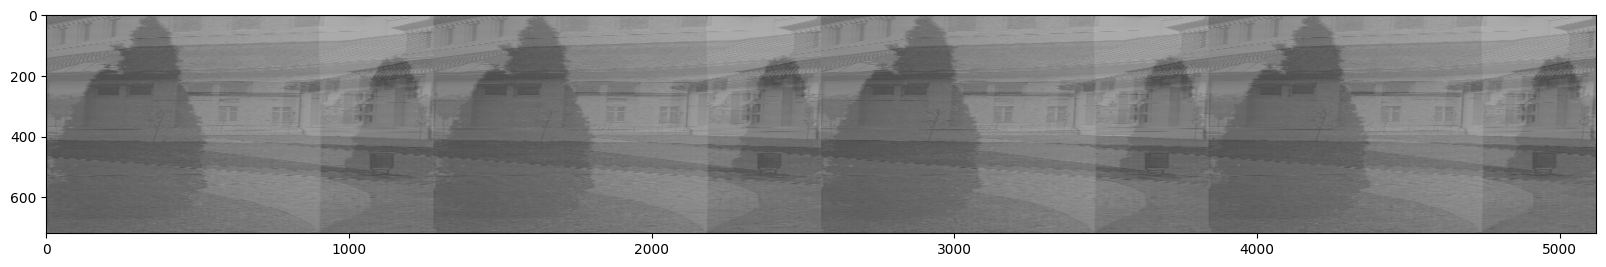

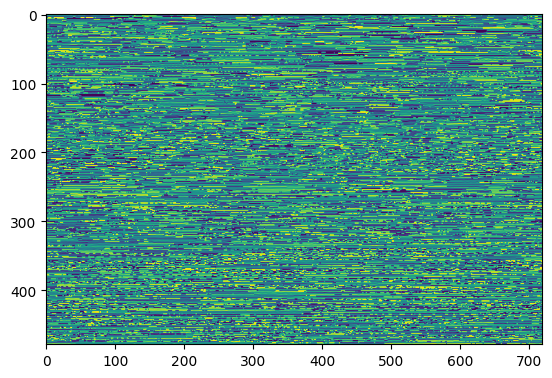

In [238]:
plt.imshow(np.diff(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), axis=0))